In [1]:
import px4tools
%pylab inline


d = px4tools.ulog.cached_log_processing(
    log='./logs/01-18-17-gyro-bias.ulg',
    msg_filter='sensor_gyro',
    processing_func=lambda x: x['sensor_gyro_0'].resample('1 s').agg('mean'),
    save_path='./logs/01-18-17-gyro-bias-sensor_gyro_0.pkl',
    force_processing=False)
d = d['10 min': '3 h 50 m']

def temp_fit(d, debias):
    temp = d.t_sensor_gyro_0__f_temperature.ffill()
    gx = d.t_sensor_gyro_0__f_x.ffill()
    gy = d.t_sensor_gyro_0__f_y.ffill()
    gz = d.t_sensor_gyro_0__f_z.ffill()

    if debias:
        gx -= gx.mean()
        gy -= gy.mean()
        gz -= gz.mean()

    Y = np.vstack([gx, gy, gz])
    c = np.ones(Y.shape[1])
    X = np.vstack([temp**3, temp**2, temp, c])
    # Y = Theta*X -> Theta = YX^+
    Theta = Y.dot(np.linalg.pinv(X))
    Theta
    
    print('X shape', X.shape)
    print('Y shape', Y.shape)
    print('Theta shape', Theta.shape)


    plt.plot(temp, 1e3*gx)
    plt.plot(temp, 1e3*gy)
    plt.plot(temp, 1e3*gz)
    plt.plot(temp, 1e3*Theta[0,:].dot(X))
    plt.plot(temp, 1e3*Theta[1,:].dot(X))
    plt.plot(temp, 1e3*Theta[2,:].dot(X))
    plt.xlabel('temp, C')
    plt.ylabel('bias, mrad/s')
    plt.grid()
    #plt.gca().set_ylim(-10, 10)
    return Theta

attempting to monkey patch pandas timedelta series plotting
monkey patch suceeded
Populating the interactive namespace from numpy and matplotlib


In [12]:
#data = px4tools.read_ulog('/home/jgoppert/logs/01-03-17-mhkabir-pixhawk2.ulg')

X shape (4, 13260)
Y shape (3, 13260)
Theta shape (3, 4)


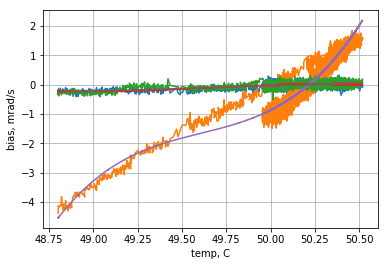

In [3]:
Theta_debias = temp_fit(d, True)

X shape (4, 13260)
Y shape (3, 13260)
Theta shape (3, 4)


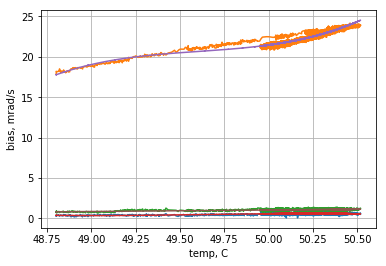

In [4]:
Theta = temp_fit(d, False)

# Recursive Algorithm

In [5]:
import sympy
sympy.init_printing()

Theta = sympy.Matrix(sympy.symbols(
    'theta_0:3_0:4')).reshape(3,4)

def Y(n):
    return sympy.Matrix(sympy.symbols(
        'G_x:z_0:{:d}'.format(n+1))).T.reshape(3, n+1)

def C(n):
    return sympy.ones(n+1, 1)

def T(n):
    return sympy.Matrix(sympy.symbols('T_0:{:d}'.format(n+1)))

def T2(n):
    return T(n).multiply_elementwise(T(n))

def T3(n):
    return T2(n).multiply_elementwise(T(n))

def X(n):
    return C(n).row_join(T(n)).row_join(T2(n)).row_join(T3(n)).T

This let's us derive a recurisve form.

$Y = \Theta X$ 

$Y X^T = \Theta X X^T$

We accumulate $Y X^T$ and $X X^T$ since they are of fixed size
and there is a recursion relation as shown below.

At the end we perform the inverse. This is the same as a pseuod-inverse
solution but done recursively.

$\Theta = Y X^T (X X^T)^{-1}$


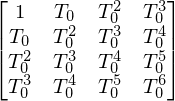

In [6]:
X(0)*X(0).T

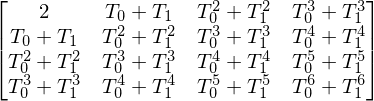

In [7]:
X(1)*X(1).T

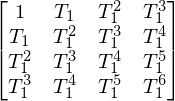

In [8]:
dX = X(1)*X(1).T - X(0)*X(0).T
dX

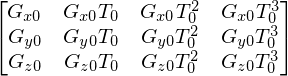

In [9]:
Y(0)*X(0).T

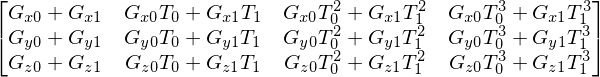

In [10]:
Y(1)*X(1).T

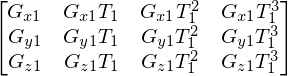

In [11]:
dYXT = Y(1)*X(1).T - Y(0)*X(0).T
dYXT